---
layout: page
title: Testes - Conceitos Avançados
nav_order: 13
---

[<img src="./colab_favicon_small.png" style="float: right;">](https://colab.research.google.com/github/icd-ufmg/icd-ufmg.github.io/blob/master/_lessons/13-poder.ipynb)


# Testes - Conceitos Avançados
{: .no_toc .mb-2 }

Explorar conceitos como poder e tipos de erro
{: .fs-6 .fw-300 }

{: .no_toc .text-delta }
Resultados Esperados

1. Entendimento de erros tipo 1 e tipo 2
1. Entendimento de poder de testes
1. Entendimento de *p-hacking*

---
**Sumário**
1. TOC
{:toc}
---

In [1]:
# -*- coding: utf8

from scipy import stats as ss

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
plt.style.use('seaborn-colorblind')

plt.rcParams['figure.figsize']  = (16, 10)
plt.rcParams['axes.labelsize']  = 20
plt.rcParams['axes.titlesize']  = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 4

In [3]:
plt.ion()

In [4]:
def despine(ax=None):
    if ax is None:
        ax = plt.gca()
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

## Introdução

Usando dados que existem publicamente, um professor de Computação tentou fazer uso de testes de hipóteses para verificar uma lenda francesa de que existem mais nascimentos em dias de lua cheia.

Os dados podem ser coletados abaixo, aqui vamos fazer uso das estatísticas já computadas.

1. Nascimentos por dia na França https://insee.fr/fr/statistiques/fichier/2904770/T79jnais.xls
1. Dias de Lua Cheia https://www.timeanddate.com/moon/phases/france/paris

### Primeiro Teste

Ao filtrar os dados (até 31 de Dezembro de 2016), o professor formulou na sua hipótese. A mesma foi feita com base na seguinte intuição. Para ter alguma evidência da lenda acima, a fração de crianças que nascem em dias de lua cheia, $p_{\text{nasc_lua_cheia}}$, tem que ser estatisticamente diferente (na verdade maior) do que a fração de dias de lua cheia, $p_{\text{lua_cheia}}$. A ideia aqui é a seguinte. Caso os nascimentos sejam uniformemente distribuídos nos dias, independente de lua cheias ou não, $p_{\text{nasc_lua_cheia}} = p_{\text{lua_cheia}}$. O Diagrama abaixo mostra essa ideia, observe como caso tenhamos o mesmo número independente de dias, as frações são iguais.

```
[ lua cheia ] [ dia normal ] [ dia normal ] [ lua cheia ] [ dia normal ]
[ 100 nasc  ] [ 100 nasc   ] [ 100 nasc   ] [ 100 nasc  ] [ 100 nasc   ]
```

Acima, $ p_{\text{lua_cheia}} = 2 / 5$. Assim como, $p_{\text{nasc_lua_cheia}} = 200 / 500 = 2 / 5$. Ou seja tudo é igual. Agora, caso existam mais nascimentos em dias de lua cheia, as frações ficam desbalanceadas.

```
[ lua cheia ] [ dia normal ] [ dia normal ] [ lua cheia ] [ dia normal ]
[ 120 nasc  ] [ 100 nasc   ] [ 100 nasc   ] [ 120 nasc  ] [ 100 nasc   ]
```

Existem algumas problemas filosóficos com a ideia acima. Uma quantidade é uma fração de nascimentos, a outra quantidade é uma fração de dias. De qualquer forma, como frações não tem unidade, podemos comparar as duas. Vamos em frente então. O professor então decide escrever sua hipótese nula:

* H0: $p_{\text{lua_cheia}} = p_{\text{nasc_lua_cheia}}$


Pare para pensar qual o impacto de rejeitar esta nula? Uma das frações é, estatisticamente falando, maior do que a outra. Mostrando **evidência** de que existem mais ou menos nascimentos em dias de lua cheia. Agora vamos fazer as contas. Existem $606$ dias de lua cheia. Além do mais, existem outros $17292$ dias sem lua cheia nos dados acima. Assim, a probabilidade de nascer em um dia de lua cheia é:

$p_{\text{lua_cheia}} = \frac{606}{17292 + 606} = 0.033858531679517266$

Além do mais, nos dias de lua cheia nasceram $1,295,426$ crianças. Nos outros dias nasceram $36,715,887$ crianças.

$p_{\text{nasc_lua_cheia}} = \frac{1295426}{1295426 + 36715887} = 0.034080011916452345$

As variâncias (e desvios padrões) são facilmente aproximadas via $p(1-p)$. Com tais dados em mão, o professor rapidamente computou os ICs dos nascimentos em dias de lua cheia!

In [5]:
n = 1295426 + 36715887
p = 1295426 / n
s = np.sqrt(p * (1 - p)) # desvio, raiz da var

print(p)
print(p - 1.96 * s / np.sqrt(n))
print(p + 1.96 * s / np.sqrt(n))

0.034080011916452345
0.03402233260315983
0.03413769122974486


$I_{\text{lua}} = (0.0340, 0.0341)$

Assim ele pensou, claramente tal IC vai capturar $p_{\text{lua_cheia}}$:

In [6]:
n = 17292 + 606
p = 606 / n
print(p)

0.033858531679517266


Plotando a distribuição amostral (sem bootstrap, mas como é uma média seria o mesmo resultado)

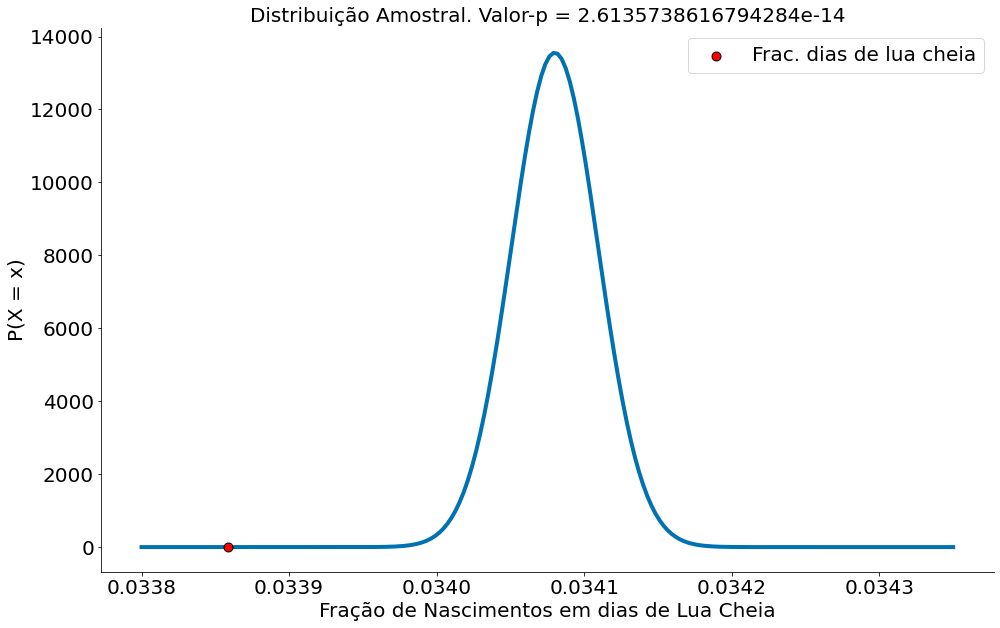

In [7]:
n = 1295426 + 36715887
p = 1295426 / n
s = np.sqrt(p * (1 - p))

mu_amostral = p
sd_amostral = s / np.sqrt(n)
dist_amostral = ss.distributions.norm(loc=p, scale=sd_amostral)


x = np.linspace(0.0338, 0.03435, 200)
plt.plot(x, dist_amostral.pdf(x=x), zorder=1)

obs = [0.033858531679517266] #observado: dias de lua cheia
p_obs = dist_amostral.pdf(x=obs)
plt.scatter(obs, p_obs, color='red', edgecolor='k', zorder=2, s=80, label='Frac. dias de lua cheia')
plt.ylabel('P(X = x)')
plt.xlabel('Fração de Nascimentos em dias de Lua Cheia')
p_val = dist_amostral.cdf(obs[0])
plt.title('Distribuição Amostral. Valor-p = {}'.format(p_val))
plt.legend()
despine()

**Erramos!** Parece que, estatisticamente, existem mais nascimentos em dias de lua cheia! O IC não captura a outra fração. Lendo da forma correta:

*Caso fosse possível replicar os nascimentos nos n = 38M (quase 38 milhões) de nascimentos, em 95% dos casos a fração de nascimentos de crianças não vai incluir o valor 0.033 (fração de dias de lua cheia). Assim, parece que uma fração é maior do que a outra, mostrando que evidências que existem mais nascimentos em dias de luas cheia (vide diagramas acima).*

Antes de continuar, é importante dizer que existem vários problemas com essa abordagem. Segue alguns:

1. Observamos o IC apenas de uma fração. Ao fazer o IC da outra fração a resposta muda! Qual o motivo?!
1. Mesmo o teste rejeitando a nula, a diferença é quase nada!!! Será que queremos isto!
   1. Sendo justo, o professor fez o teste mais corretamente do que compartivo de ICs. Mas não quis replicar aqui por brevidade.
1. Estamos comparando frações de coisas diferentes!

O terceiro problema será resolvido abaixo. O primeiro e segundo serão abordados depois.

### Segundo Teste: Mais Correto!

Existem $606$ dias de lua cheia. Além do mais, existem $1,295,426$ nascimentos em tais dias. Assim, o número esperado de nascimentos em dias de lua cheia é de:

$\bar{x}_{\text{lua}} = \frac{1295426}{606} = 2137$

Nos outros dias nasceram $36,715,887$ crianças num total de $17,292$, assim:

$\bar{x}_{\text{outros}} = \frac{36715887}{17292} = 2123$

Note que aqui nos dois casos eu estou com NASCIMENTOS POR DIAS. Mesma unidade. Os desvios padrões dos dados são:

$s_{\text{lua}} = 57585$

$s_{\text{outros}} = 59232$

Com tais dados em mão, o professor rapidamente computou os ICs.

In [8]:
2137 - 1.96 * 57585 / np.sqrt(606)

-2447.892215345594

In [9]:
2137 + 1.96 * 57585 / np.sqrt(606)

6721.892215345594

$I_{\text{lua}} = (-2447, 6721)$

Da mesma forma, fez as contas para os dias sem lua.

In [10]:
print(2123 - 1.96 * 59232 / np.sqrt(17292))
print(2123 + 1.96 * 59232 / np.sqrt(17292))

1240.1440363518727
3005.8559636481273


$I_{\text{outros}} = (1240, 3005)$

Aqui, independente da direção um IC captura a média do outro. UFA!

Agora ainda podemos nos perguntar, qual o motivo do primeiro teste falhar? Matematicamente, nada foi feito da forma errada. O argumento de comparar frações é estranho mas é válido. Vamos entender abaixo.

Antes disto, para finalizar, segue a amostral!

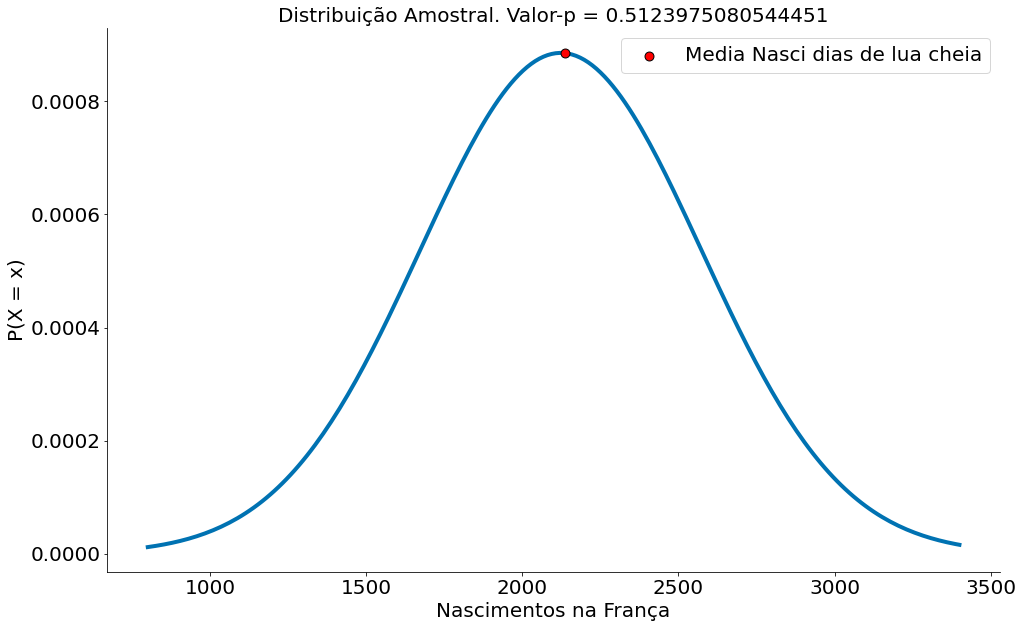

In [11]:
mu_amostral = 2123
sd_amostral = 59232 / np.sqrt(17292)
dist_amostral = ss.distributions.norm(loc=mu_amostral, scale=sd_amostral)


x = np.linspace(800, 3400, 200)
plt.plot(x, dist_amostral.pdf(x=x), zorder=1)

obs = [2137] #observado
p_obs = dist_amostral.pdf(x=obs)
plt.scatter(obs, p_obs, color='red', edgecolor='k', zorder=2, s=80, label='Media Nasci dias de lua cheia')
plt.ylabel('P(X = x)')
plt.xlabel('Nascimentos na França')
p_val = dist_amostral.cdf(obs[0])
plt.title('Distribuição Amostral. Valor-p = {}'.format(p_val))
plt.legend()
despine()

## Poder de Testes

Para entender o problema do comparativo inicial (o de frações), vamos relembrar do caso mais simples de moedas viesadas e não viesadas. Em particular, vamos assumir um lançamento de 100 moedas. Isto é, vamos contar quantas vezes as mesmas caem em cara.

Como já falamos, tais dados podem ser modelados por uma Binomial. Sendo $p$ a proporção de caras e $n$ o número de vezes que lanço a moeda:

$$k \sim Binomial(p, n)$$

Ou seja, podemos amostrar o número de caras $k$ usando uma Binomial.

In [12]:
N = 100
alpha = 0.05

Usando o código da Binomial em Python, temos várias funções que nos ajuda. Uma delas define qual é o intervalo onde caem 95% dos lançamentos. Então, esta é a faixa esperada de uma moeda não viesada ($p=.5$).

In [13]:
lower, upper = ss.binom.interval(1 - alpha, N, 0.5)
(lower, upper)

(40.0, 60.0)

Abaixo vemos alguns plots:
1. 95% dos casos na região verde
1. 5% na vermelha

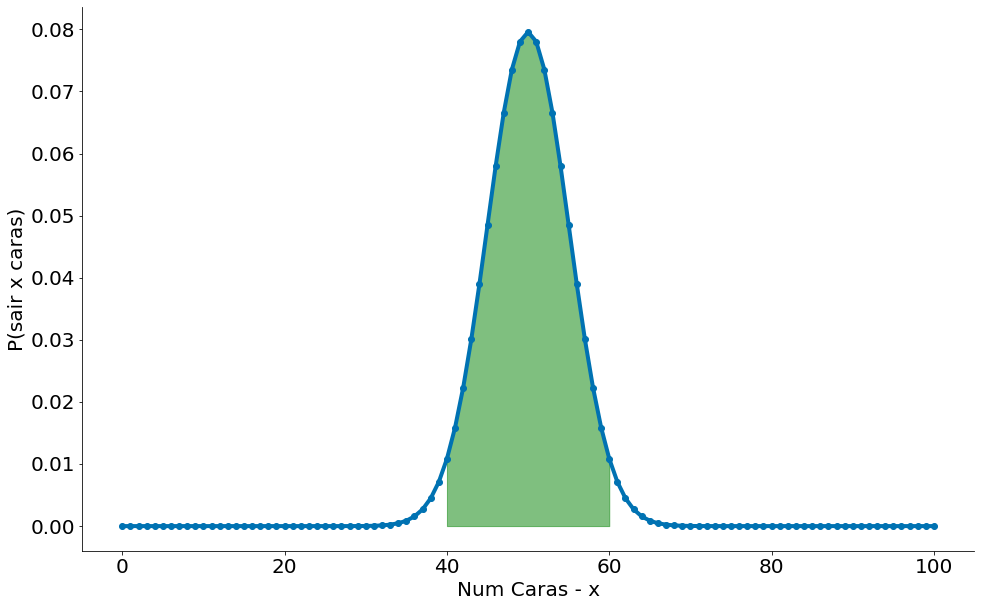

In [14]:
x = np.arange(0, 101) # Valores no eixo x
prob_binom = ss.distributions.binom.pmf(x, N, 0.5)
plt.plot(x, prob_binom, 'o-')
plt.xlabel('Num Caras - x')
plt.ylabel('P(sair x caras)')

x2 = np.arange(40, 61) # Valores no eixo x
prob_binom = ss.distributions.binom.pmf(x2, N, 0.5)
plt.fill_between(x2, prob_binom, color='g', alpha=0.5)

despine()

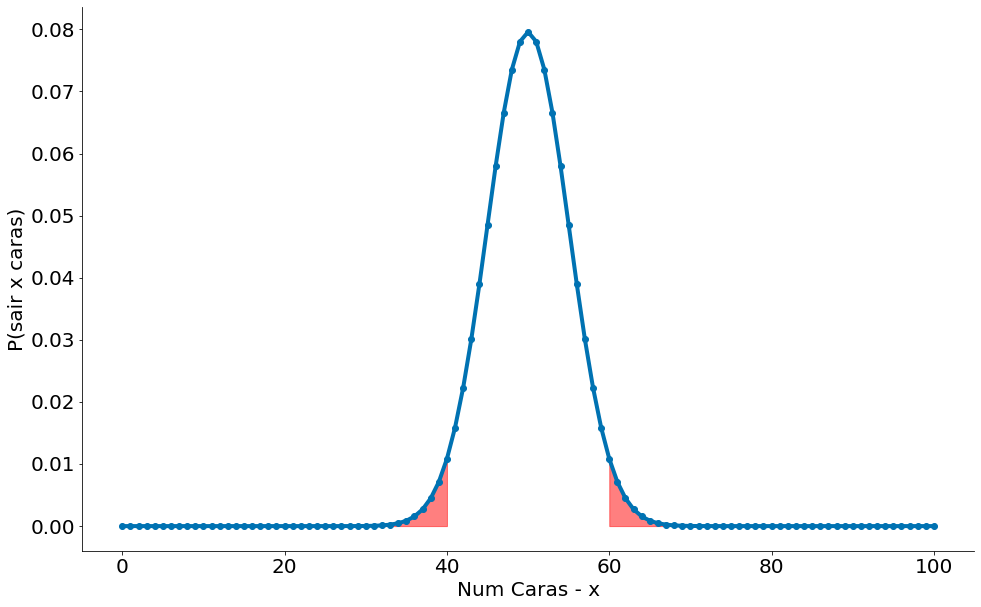

In [15]:
x = np.arange(0, 101) # Valores no eixo x
prob_binom = ss.distributions.binom.pmf(x, N, 0.5)
plt.plot(x, prob_binom, 'o-')
plt.xlabel('Num Caras - x')
plt.ylabel('P(sair x caras)')

x2 = np.arange(60, 100) # Valores no eixo x
prob_binom = ss.distributions.binom.pmf(x2, N, 0.5)
plt.fill_between(x2, prob_binom, color='r', alpha=0.5)

x3 = np.arange(0, 41) # Valores no eixo x
prob_binom = ss.distributions.binom.pmf(x3, N, 0.5)
plt.fill_between(x3, prob_binom, color='r', alpha=0.5)

despine()

## Tipos de Erros

Vamos agora definir nossa hipótese nula:

$H_0$: **p == 0.5**

Ao realizar um experimento, lançar algumas moedas para cima, caso eu rejeite $H_0$ tenho evidência de que a moeda não é justa (não-viesada). Precisamos tomar uma decisão sobre a *significância*, que mede o quanto estamos dispostos a cometer um *erro do tipo 1* (“falso positivo”), no qual rejeitamos $H_0$, embora ela seja verdade.Vamos escolher $5\%$ (ver slides sobre a discussão de Fisher).

Considere o teste que rejeita $H_0$ se $X$ estiver fora dos limites dados por: (40, 60). Ver plots acima. Para entender um erro do tipo 1, considere a figura abaixo que compara noessa moeda com outra onde $p=0.6$. A região rosa consiste de mais ou menos $50%$ dos casos desta moeda. Note que tais casos todos caem no intervalo de $2.5\%$ (para a direita, maior, metade de $5\%$). Podemos errar, mas esperamos bem mais vezes $50\%$ de que a moeda injusta caia no intervalo. 

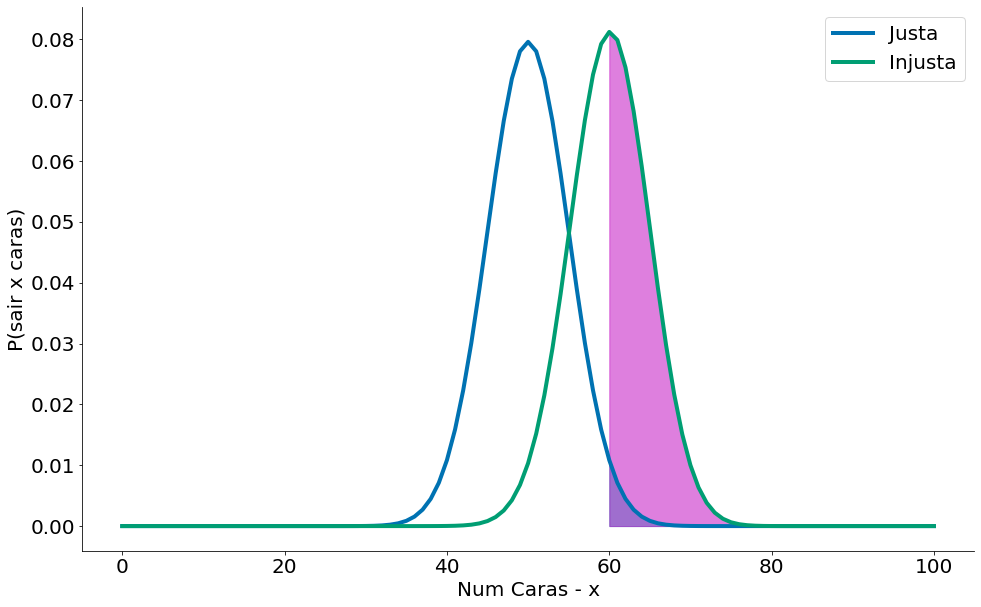

In [16]:
x = np.arange(0, 101) # Valores no eixo x
prob_binom_fair = ss.distributions.binom.pmf(x, N, 0.5)
prob_binom_unfair = ss.distributions.binom.pmf(x, N, 0.6)
plt.plot(x, prob_binom_fair, label='Justa')
plt.plot(x, prob_binom_unfair, label='Injusta')
plt.xlabel('Num Caras - x')
plt.ylabel('P(sair x caras)')

x2 = np.arange(60, 100) # Valores no eixo x
fill_prob_binom_fair = ss.distributions.binom.pmf(x2, N, 0.5)
plt.fill_between(x2, fill_prob_binom_fair, color='c', alpha=0.5)

fill_prob_binom_unfair = ss.distributions.binom.pmf(x2, N, 0.6)
plt.fill_between(x2, fill_prob_binom_unfair, color='m', alpha=0.5)

plt.legend()
despine()

Portanto, assumindo que $p$ é realmente igual a $0.5$ (ou seja, $H_0$ é verdade), há apenas $5\%$ de chance de observarmos um $X$ que está fora desse intervalo, que é o significado exato que queríamos. Dito de forma diferente, se $H_0$ for verdadeiro, então, aproximadamente $19$ vezes de $20$ este teste dará o resultado correto.

Também estamos frequentemente interessados no *poder* (ou *power*) de um teste, que é a probabilidade de não cometer um *erro do tipo 2*, em que não podemos rejeitar $H_0$, mesmo ela sendo falsa. Para medir isso, temos que especificar o que é exatamente $H_0$ ser falsa. (Saber apenas que $p$ não é $0.5$ não fornece muitas informações sobre a distribuição de $X$.) Em particular, vamos verificar o que acontece se $p$ for, na verdade, $0.06$, de modo que a moeda seja ligeiramente tendenciosa a dar "cara". Nesse caso, gostaríamos de rejeitar $H_0$.

Tal erro, capturado $\beta$, pode ser ilustrado na região onde a moeda viesada cai no intervalo (40, 60). Aqui, uma moeda viesada parece justa!

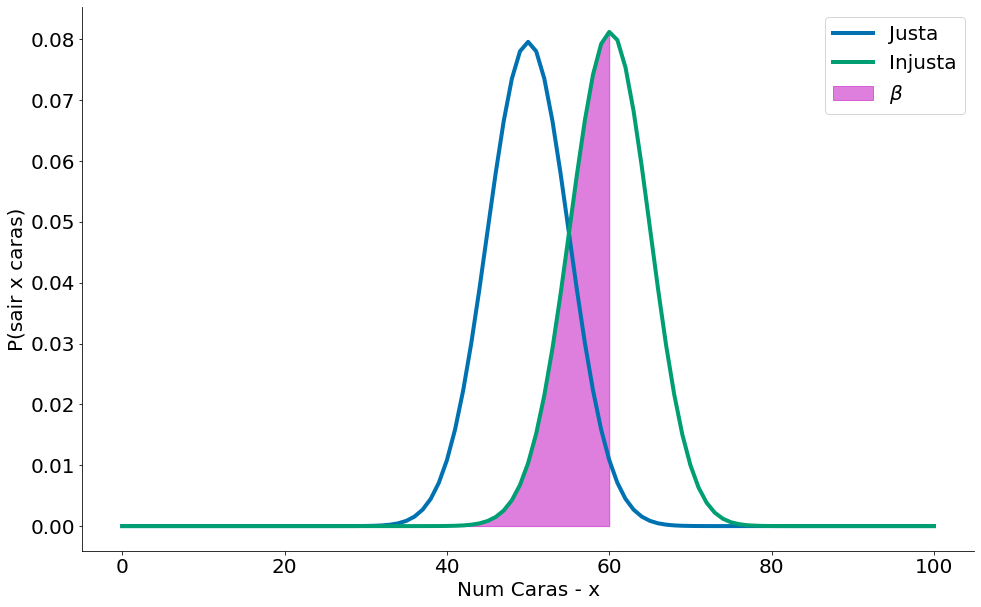

In [17]:
x = np.arange(0, 101) # Valores no eixo x
prob_binom_fair = ss.distributions.binom.pmf(x, N, 0.5)
prob_binom_unfair = ss.distributions.binom.pmf(x, N, 0.6)
plt.plot(x, prob_binom_fair, label='Justa')
plt.plot(x, prob_binom_unfair, label='Injusta')
plt.xlabel('Num Caras - x')
plt.ylabel('P(sair x caras)')

x2 = np.arange(40, 61) # Valores no eixo x
fill_prob_binom_unfair = ss.distributions.binom.pmf(x2, N, 0.6)
plt.fill_between(x2, fill_prob_binom_unfair, color='m', alpha=0.5, label=r'$\beta$')

plt.legend()
despine()

Usando a CDF, poemos ver tais chances.! Em particular queremos:

$P(X <= 60) - P(x <= 40)$

In [18]:
beta = ss.binom.cdf(upper, N, 0.6) - ss.binom.cdf(lower, N, 0.6)
beta

0.5378821927269787

x = np.arange(0, 101) # Valores no eixo x
y = ss.binom.cdf(x, N, 0.6)
plt.plot(x, y)
plt.xlabel('Num Caras - x')
plt.ylabel('P(X < x)')

x2 = np.arange(40, 61) # Valores no eixo x
fill = ss.binom.cdf(x2, N, 0.6)
plt.fill_between(x2, fill, color='m', alpha=0.5, label=r'$\beta$')

O poder é dado por 1-$\beta$.

In [19]:
1 - beta

0.4621178072730213

As análises acima indicam que, quando a moeda for tendenciosa com 𝑝=0.6, 53% das vezes a variável 𝑋 terá um valor dentro do intervalo [40,60]. Em outras palavras, o nosso teste vai rejeitar 𝐻0 corretamente quando 𝑝=0.6.

Observe que o valor de $\beta$ é bem menor (quase zero) quando uma moeda é muito viesada. Outra forma de ver é que temos muito poder $1-\beta$.

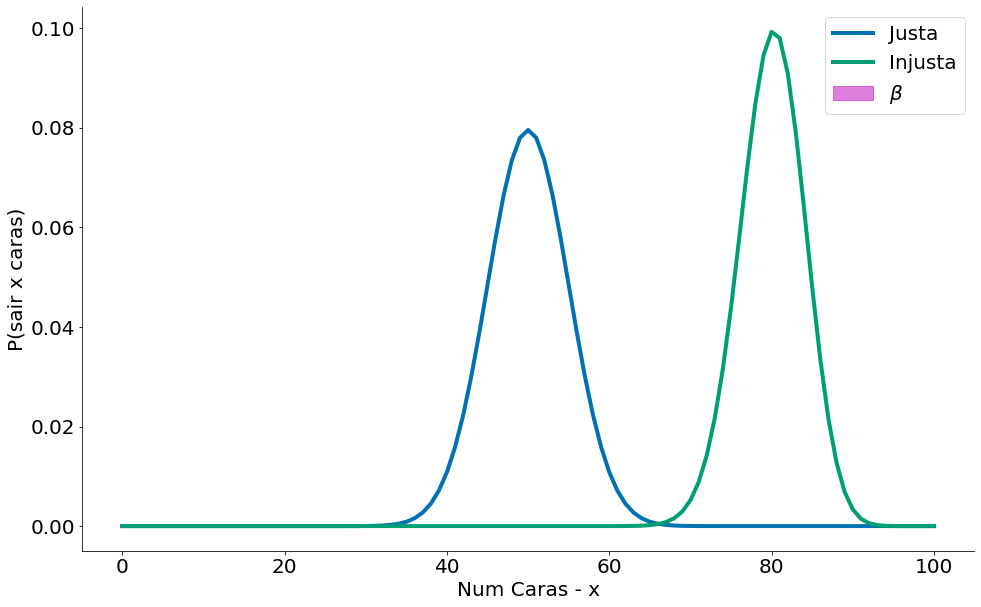

In [20]:
x = np.arange(0, 101) # Valores no eixo x
prob_binom_fair = ss.distributions.binom.pmf(x, N, 0.5)
prob_binom_unfair = ss.distributions.binom.pmf(x, N, 0.8)
plt.plot(x, prob_binom_fair, label='Justa')
plt.plot(x, prob_binom_unfair, label='Injusta')
plt.xlabel('Num Caras - x')
plt.ylabel('P(sair x caras)')

x2 = np.arange(40, 61) # Valores no eixo x
fill_prob_binom_unfair = ss.distributions.binom.pmf(x2, N, 0.8)
plt.fill_between(x2, fill_prob_binom_unfair, color='m', alpha=0.5, label=r'$\beta$')

plt.legend()
despine()

Definindo uma função power (abaixo), podemos agora explorar melhor o poder para diferentes moedas viesadas.

In [21]:
def power(alt, n):
    lower, upper = ss.binom.interval(1 - 0.05, n, 0.5)
    beta = ss.binom.cdf(upper, n, alt) - ss.binom.cdf(lower, n, alt)
    return 1 - beta

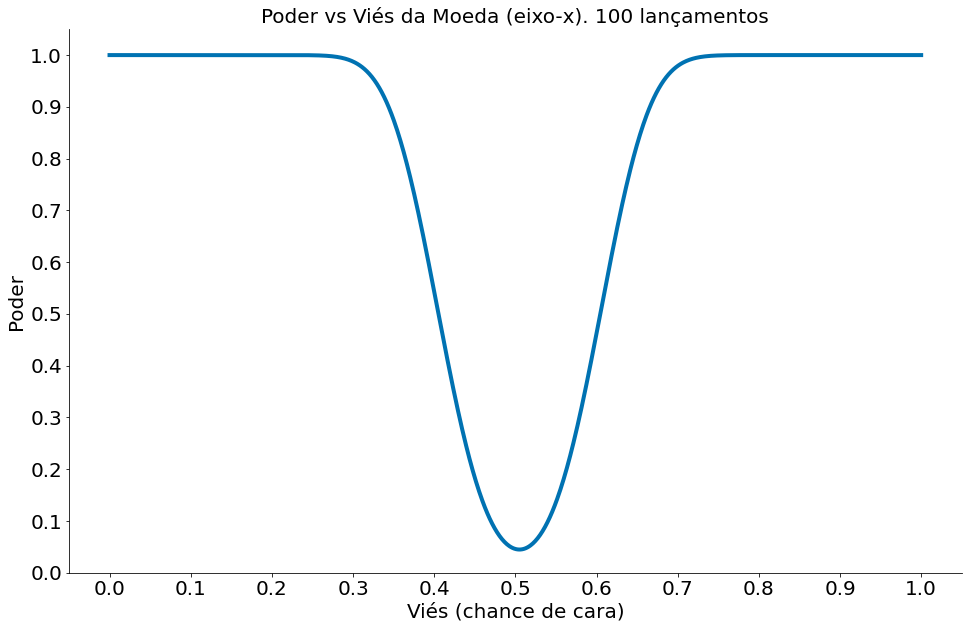

In [22]:
fig, ax = plt.subplots(1, 1)
ax.set_title('Poder vs Viés da Moeda (eixo-x). 100 lançamentos')

def plot_power(n, ax, **kwargs):
    alternativas = np.linspace(0, 1, 1000)
    ax.plot(alternativas, power(alternativas, n), **kwargs)
    ax.set_xticks(np.arange(0,1.1, 0.1))
    ax.set_yticks(np.arange(0,1.1, 0.1))
    ax.set_ybound((0, 1.05))
    ax.set_ylabel('Poder')
    ax.set_xlabel('Viés (chance de cara)')
    
plot_power(N, ax)
despine()

Como esperado, temos muito mais poder quando estamos mais longe de $p=0.5$. Isto é o nosso efeito. Ao sumarizar um teste de hipóteses, é bom ver qual é a distância entre o observado e o esperado (no modelo nulo). Posso dizer chegar em conclusões erradas para uma moeda onde $p=0.51$. 

Um outro fator importante é que quanto maior nossos dados mais poder. Ou seja, mais chances de dizer $p=0.51$ é viesado. Porém qual o efeito prático disto? Moedas não viesadas existem apenas na teoria.

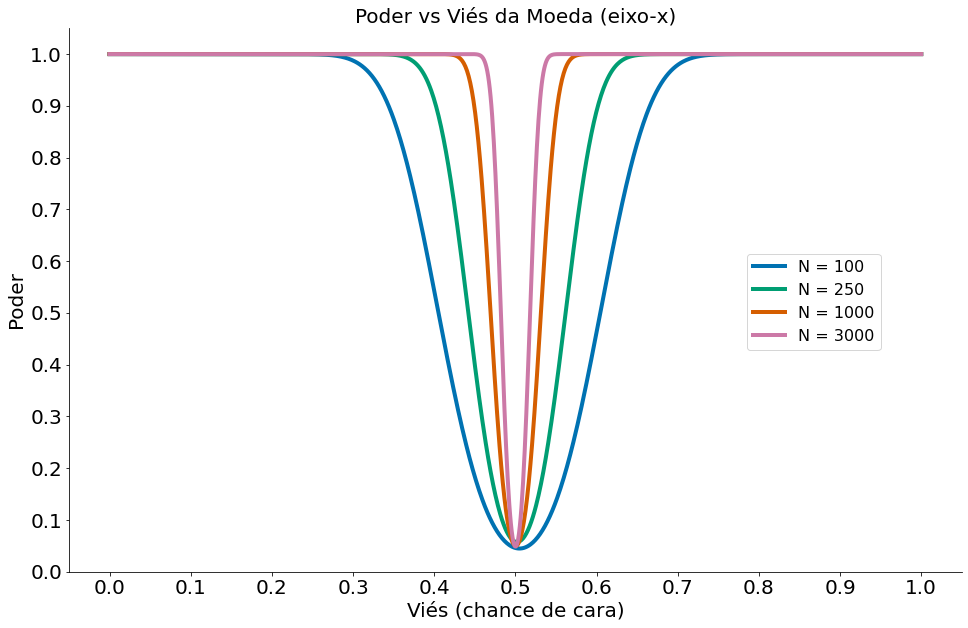

In [23]:
fig, ax = plt.subplots(1, 1)

def plot_powers(ax):
    ax.set_title('Poder vs Viés da Moeda (eixo-x)')
    plot_power(100, ax,  label="N = 100")
    plot_power(250, ax,  label="N = 250")
    plot_power(1000, ax, label="N = 1000")
    plot_power(3000, ax, label="N = 3000")
    ax.legend(bbox_to_anchor=(0.75, 0.6), loc=2, prop={'size':16})
    
plot_powers(ax)
despine()

Podemos ver como mais dados aumenta o poder. Compare o caso abaixo com o caso com 100 lançamentos!

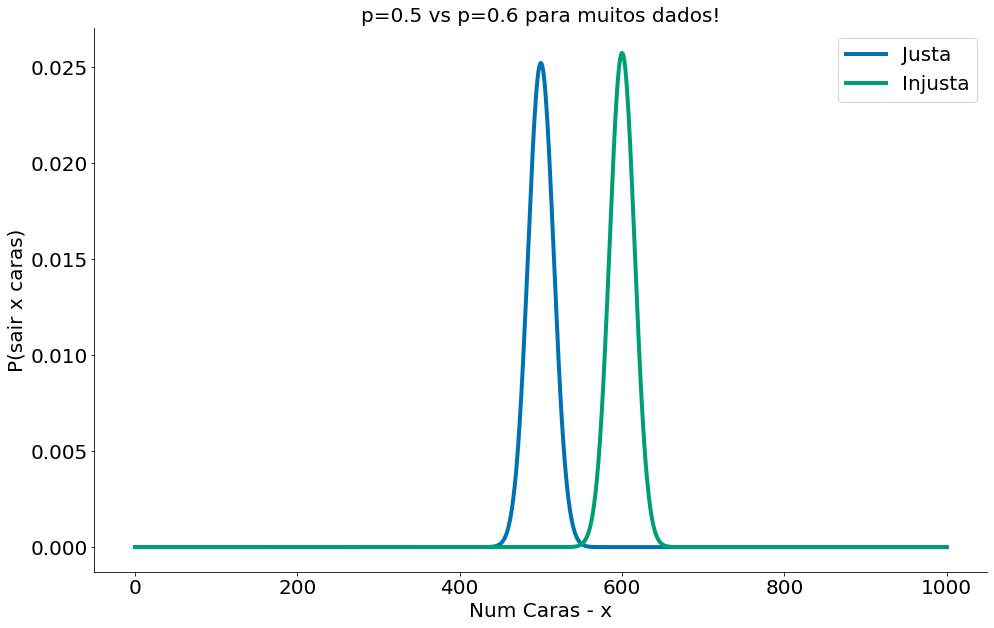

In [24]:
x = np.arange(0, 1001) # Valores no eixo x
prob_binom_fair = ss.distributions.binom.pmf(x, 1000, 0.5)
prob_binom_unfair = ss.distributions.binom.pmf(x, 1000, 0.6)
plt.plot(x, prob_binom_fair, label='Justa')
plt.plot(x, prob_binom_unfair, label='Injusta')
plt.xlabel('Num Caras - x')
plt.ylabel('P(sair x caras)')

plt.title('p=0.5 vs p=0.6 para muitos dados!')
plt.legend()
despine()

## Com Dados

Vamos fazer uso da mesma base de dados da aula de causalidade para explorar o conceito. Nesta base temos um teste A/B com um grupo de Teste e outro de Controle. Lembrando que 1.0 indica cura. Ou seja, queremos que o grupo de Teste (medicados) tenha um valor maior de 1s.

Abaixo pego os dados.

In [25]:
df = pd.read_csv('https://media.githubusercontent.com/media/icd-ufmg/material/master/aulas/13-CausalidadeRCT/bta.csv')
df.head()

,Group,Result
0,Control,1.0
1,Control,1.0
2,Control,0.0
3,Control,0.0
4,Control,0.0


Grupo de Controle

In [26]:
control = df.query('Group == "Control"')
control.head()

,Group,Result
0,Control,1.0
1,Control,1.0
2,Control,0.0
3,Control,0.0
4,Control,0.0


Grupo de Teste

In [27]:
medicados = df.query('Group != "Control"')
medicados.head()

,Group,Result
16,Treatment,1.0
17,Treatment,1.0
18,Treatment,1.0
19,Treatment,1.0
20,Treatment,1.0


Com a média de desvio padrão dos grupo é possível criar a distribuição amostral. Abaixo vamos ver as duas distribuições.

In [28]:
mu_ctrl = control['Result'].mean()
std_ctrl = control['Result'].std(ddof=1)

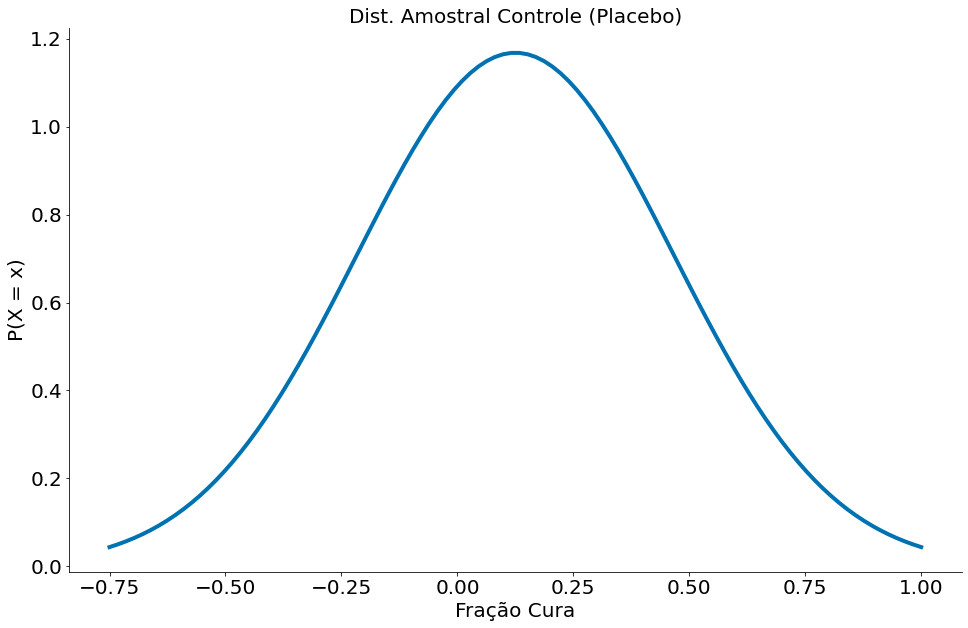

In [29]:
import scipy.stats as ss

x = np.linspace(-0.75, 1, 100)
y = ss.distributions.norm.pdf(loc=mu_ctrl, scale=std_ctrl, x=x)
plt.plot(x, y)
plt.xlabel('Fração Cura')
plt.ylabel('P(X = x)')
plt.title('Dist. Amostral Controle (Placebo)')
despine()

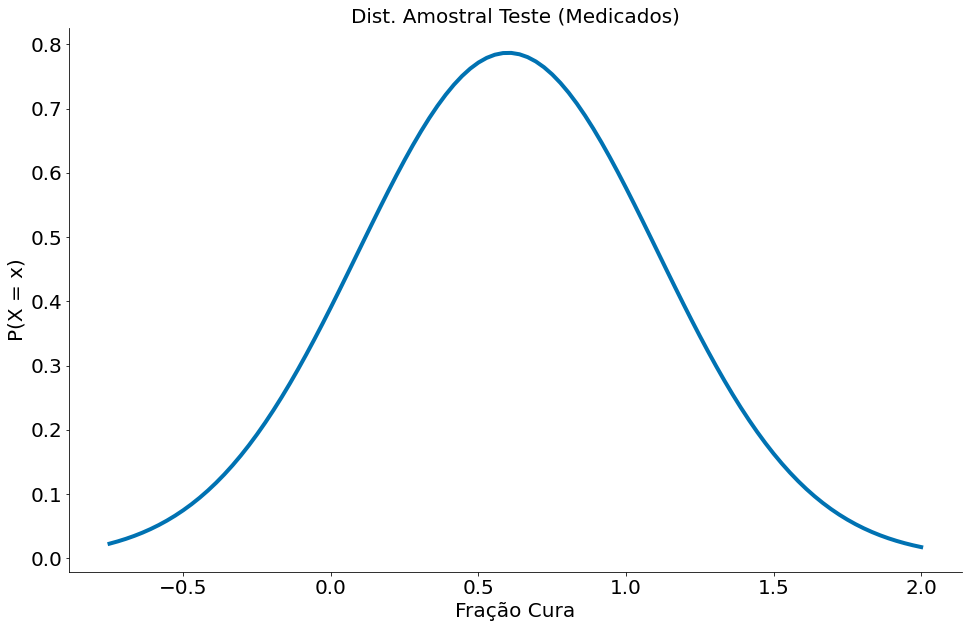

In [30]:
mu_med = medicados['Result'].mean()
std_med = medicados['Result'].std(ddof=1)

x = np.linspace(-0.75, 2, 100)
y = ss.distributions.norm.pdf(loc=mu_med, scale=std_med, x=x)
plt.title('Dist. Amostral Teste (Medicados)')
plt.plot(x, y, label='Medicados')
plt.xlabel('Fração Cura')
plt.ylabel('P(X = x)')
despine()

Agora vamos plotar as duas e mensurar o poder. Nesta base, observamos tal média para o grupo de medicados.

In [31]:
mu_med

0.6

A média para os dados de controle é:

In [32]:
mu_ctrl

0.125

Vamos criar uma hipótese.

* H0: 0.125 < 0.6. Ou seja, a média do grupo de CONTROLE é ESTATISTICAMENTE MENOR do que a média do TESTE.

Podemos observar qual a região de ACEITAÇÃO desta nula. Basta plotar a distribuição amostral do grupo de controle e a região onde caiem 95% dos dados. O plot segue abaixo. Parece que o IC dp grupo de controle vai até 0.45. Ou seja, valores observados de teste ALÉM deste rejeitam a nula.

*Existe um erro aqui que valores abaixo de zero a acima de um não seriam esperados, mas vamos ignorar tal problema. Podemos truncar a ajustar as distribuições para serem Normais truncadas, mas isso mudaria um pouco nosso entendimento do TCL.*

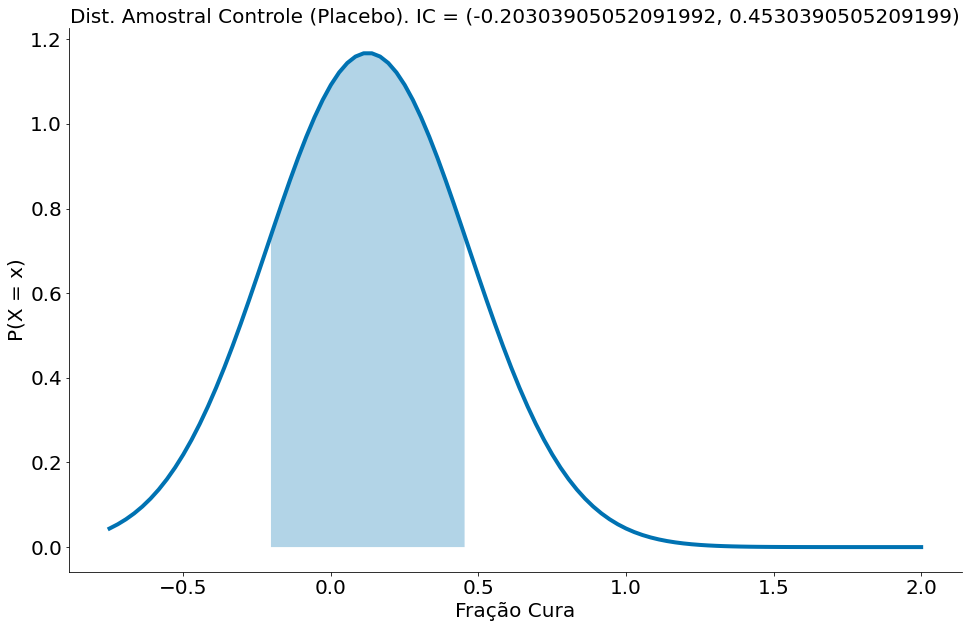

In [33]:
x = np.linspace(-0.75, 2, 100)

y = ss.distributions.norm.pdf(loc=mu_ctrl, scale=std_ctrl, x=x)
plt.plot(x, y, label='Controle')

se = 1.96 * std_ctrl / np.sqrt(len(control))
low = mu_ctrl - 1.96 * se
high = mu_ctrl + 1.96 * se
x_fill = np.linspace(low, high, 100)
y_fill = ss.distributions.norm.pdf(loc=mu_ctrl, scale=std_ctrl, x=x_fill)
plt.fill_between(x_fill, y_fill, alpha=0.3)

plt.xlabel('Fração Cura')
plt.ylabel('P(X = x)')
plt.title('Dist. Amostral Controle (Placebo). IC = ({}, {})'.format(low, high))
despine()

Como temos um segundo grupo, podemos ver qual a chance da **distribuição amostral** deste segundo grupo cair na área onde **aceitamos a nula**. Tal valor é o $\beta$. O mesmo será de uns 33%. 

* $P(H_0|H_1) = \beta = 33\%$. Este é o caso do $\beta$. Lemos a chance da H0 caso a H1 seja verdade.

Ou seja: caso seja repetido um outro experimento com o mesmo tamanho de amostra $n$, existe 33% de chance do grupo 
de medicados ter uma taxa de cura dentro do IC (região onde aceiamos a nula, é esperado) do grupo de controle.

* $P(H_1|H_0) = \alpha = 5\%$. Este é o caso do $\alpha$. Lemos a chance da H1 caso a H0 seja verdade.

Este valor é **fixo**. Não depende de dados nem de H1. Por isso é mais simples pensar apenas nele!

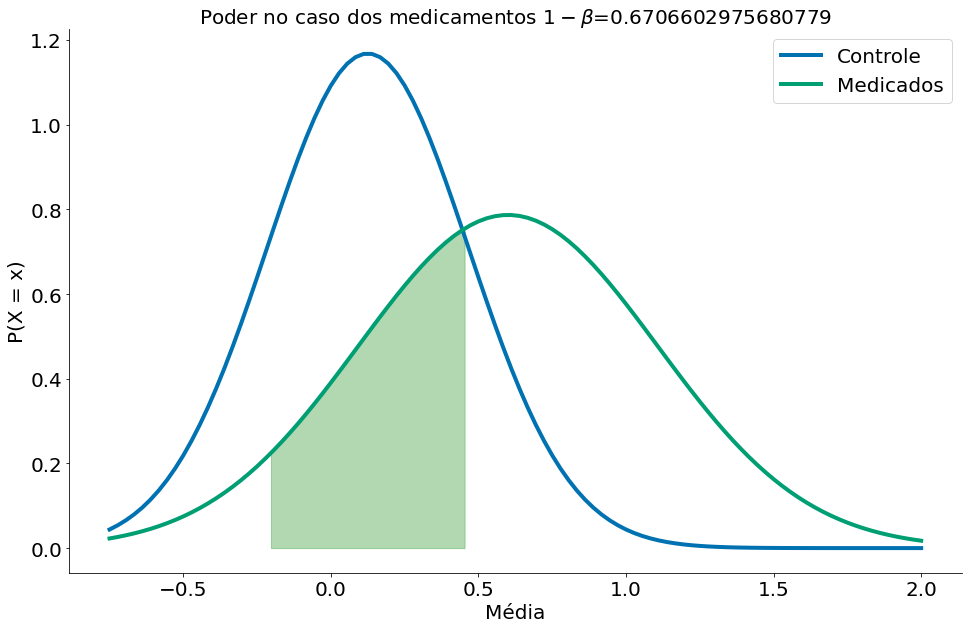

In [34]:
x = np.linspace(-0.75, 2, 100)

y = ss.distributions.norm.pdf(loc=mu_ctrl, scale=std_ctrl, x=x)
plt.plot(x, y, label='Controle')

se = 1.96 * std_ctrl / np.sqrt(len(control))
low = mu_ctrl - 1.96 * se
high = mu_ctrl + 1.96 * se
x_fill = np.linspace(low, high, 100)

y = ss.distributions.norm.pdf(loc=mu_med, scale=std_med, x=x)
plt.plot(x, y, label='Medicados')

x_fill = np.linspace(low, high, 100)
y_fill = ss.distributions.norm.pdf(loc=mu_med, scale=std_med, x=x_fill)
plt.fill_between(x_fill, y_fill, alpha=0.3, color='green')

beta = ss.distributions.norm.cdf(loc=mu_med, scale=std_med, x=high) - \
        ss.distributions.norm.cdf(loc=mu_med, scale=std_med, x=low)

plt.title(r'Poder no caso dos medicamentos $1-\beta$={}'.format(1-beta))

plt.xlabel('Média')
plt.ylabel('P(X = x)')
plt.legend()
despine()

## Dicas

Ao realizar um teste sempre indique:
1. A hipótese nula
1. Qual o tamanho da amostra
1. Qual o tamanho do efeito

Com muitas amostras, até efeitos pequenos são significativos. Porém, sem muitas consequências na prática!